## File Structure


Suppose we have following project structure:
```
.
├── data
│   ├── test            # extracted
│   │   └── audio          # all test
│   ├── test.7z         # downloaded
│   ├── train           # extracted
│   │   ├── audio          # folder with all train command/file.wav
│   │   ├── LICENSE
│   │   ├── README.md
│   │   ├── testing_list.txt
│   │   └── validation_list.txt
│   └── train.7z         # downloaded
├── kernel.ipynb      # this ipynb  
└── model-k           # folder for model, checkpoints, logs and submission.csv
```


## Appendix
Thanks __DavidS__ and __Alex Ozerin__ for their great notebooks!

In [38]:
import os
import re
import gc
import torch
import time
import random
import numpy as np
import pandas as pd
from torch import nn
from glob import glob
from scipy import signal
from pylab import rcParams
import torch.optim as optim
from scipy.io import wavfile
from scipy.fftpack import fft
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import transforms
from torch.autograd import Variable
from sklearn.datasets.lfw import Bunch
from sklearn.metrics import precision_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

The original sample rate is 16000, and we will resample it to 8000 to reduce data size.

In [2]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'data', 'train', 'audio')
test_data_path = os.path.join(root_path, 'data', 'test', 'audio')

Here are custom_fft and log_specgram functions written by __DavidS__.

In [3]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Following is the utility function to grab all wav files inside train data folder.

In [4]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

__pad_audio__ will pad audios that are less than 16000(1 second) with 0s to make them all have the same length.

__chop_audio__ will chop audios that are larger than 16000(eg. wav files in background noises folder) to 16000 in length. In addition, it will create several chunks out of one large wav files given the parameter 'num'.

__label_transform__ transform labels into dummies values. It's used in combination with softmax to predict the label.

In [5]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

Next, we use functions declared above to generate x_train and y_train.
label_index is the index used by pandas to create dummy values, we need to save it for later use.

In [6]:
%%time
labels, fnames = list_wavs_fname(train_data_path)

new_sample_rate = 8000
y = []
X = []

for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y.append(label)
        X.append(specgram)
X = np.array(X)
X = X.reshape(tuple(list(X.shape) + [1]))
y = label_transform(y)
label_index = y.columns.values
y = y.values
y = np.array(y)
del labels, fnames
gc.collect()

./data/train/audio


/home/malysheva/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


CPU times: user 6min 17s, sys: 22.7 s, total: 6min 40s
Wall time: 1min 41s


In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [8]:
X.shape, y.shape

((64841, 99, 81, 1), (64841, 12))

## Pytorch

CNN declared below.
The specgram created will be of shape (99, 81), but in order to fit into Conv2D layer, we need to reshape it.

In [34]:
num_epochs = 2
learning_rate = 0.001
nclass = 12
batch_size = 16

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 2),
            nn.Conv2d(8, 8, 2),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(8, 16, 3),
            nn.Conv2d(16, 16, 3),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(16, 32, 3),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(2240, 128),
            nn.BatchNorm1d(128),
            nn.Linear(128, nclass)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        return self.out(out)

In [17]:
tensor_X = torch.stack([torch.FloatTensor(x.transpose((2, 0, 1))) for x in x_train])
tensor_y = torch.LongTensor([int(y.argmax()) for y in y_train])
tensor_y.size(0), tensor_X.size(0)

(58356, 58356)

In [18]:
train_dataset = utils.TensorDataset(tensor_X, tensor_y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [35]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
ans = []
for j in range(num_epochs):
    total_loss = 0
    
    for i, (x_batch, labels) in enumerate(tqdm.tqdm_notebook(train_loader)):
        x_batch = Variable(x_batch) # [32, 1, 99, 81]
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = cnn(x_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        if i % 100 == 0:
            print('Iter number ' + str(i) + ' Loss: ' + str(loss.data[0]))
        ans.append(float(loss.data[0]))
    print('Epoch number ' + str(j) + ' Loss: ' + str(loss.data[0]))
            

Iter number 0 Loss: 2.5014357566833496

Iter number 100 Loss: 1.7110211849212646
Iter number 200 Loss: 1.131559133529663
Iter number 300 Loss: 1.1592051982879639
Iter number 400 Loss: 1.5091407299041748
Iter number 500 Loss: 0.7984410524368286
Iter number 600 Loss: 1.318733811378479
Iter number 700 Loss: 1.1931114196777344
Iter number 800 Loss: 1.0480334758758545
Iter number 900 Loss: 1.7127751111984253
Iter number 1000 Loss: 0.9651362895965576
Iter number 1100 Loss: 1.0541030168533325
Iter number 1200 Loss: 1.574629545211792
Iter number 1300 Loss: 1.8510817289352417
Iter number 1400 Loss: 1.0902281999588013
Iter number 1500 Loss: 1.151135802268982
Iter number 1600 Loss: 1.1689348220825195
Iter number 1700 Loss: 1.471021056175232
Iter number 1800 Loss: 0.8601767420768738
Iter number 1900 Loss: 1.4263067245483398
Iter number 2000 Loss: 1.0394508838653564
Iter number 2100 Loss: 2.0021798610687256
Iter number 2200 Loss: 1.2972180843353271
Iter number 2300 Loss: 1.1666806936264038
Iter num

Iter number 0 Loss: 0.9321805834770203
Iter number 100 Loss: 0.8583245277404785
Iter number 200 Loss: 1.375566005706787
Iter number 300 Loss: 1.2283364534378052
Iter number 400 Loss: 1.2183163166046143
Iter number 500 Loss: 1.2005598545074463
Iter number 600 Loss: 1.0201680660247803
Iter number 700 Loss: 1.16251802444458
Iter number 800 Loss: 0.5628142356872559
Iter number 900 Loss: 0.9028528928756714
Iter number 1000 Loss: 0.9735923409461975
Iter number 1100 Loss: 0.5922396183013916
Iter number 1200 Loss: 0.922799289226532
Iter number 1300 Loss: 1.1669161319732666
Iter number 1400 Loss: 0.5952207446098328
Iter number 1500 Loss: 0.7800314426422119
Iter number 1600 Loss: 0.497522234916687
Iter number 1700 Loss: 1.2383896112442017
Iter number 1800 Loss: 0.8962238430976868
Iter number 1900 Loss: 0.5261179804801941
Iter number 2000 Loss: 1.6214396953582764
Iter number 2100 Loss: 0.7726888060569763
Iter number 2200 Loss: 1.4350261688232422
Iter number 2300 Loss: 1.1918060779571533
Iter numb

## Plot

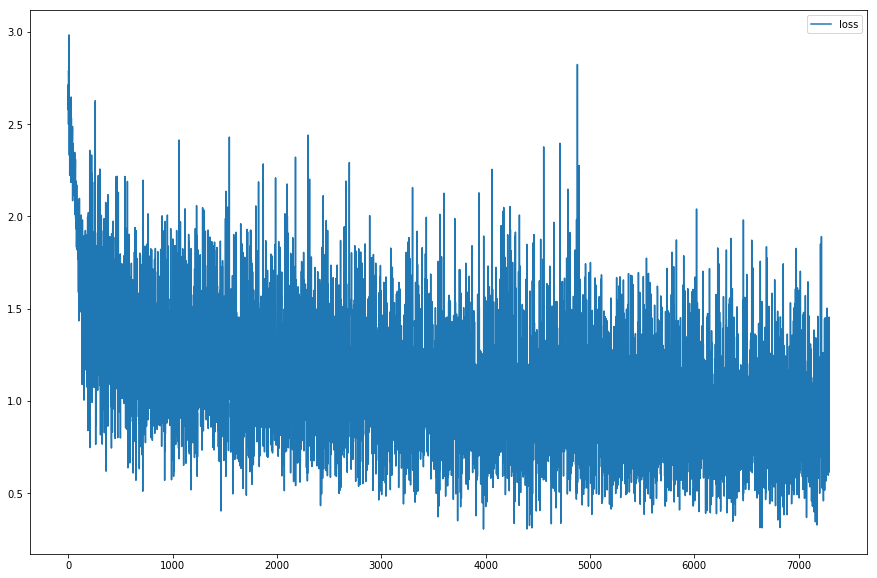

In [39]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
x = np.arange(len(ans))
plt.plot(x, ans)       
plt.legend(['loss'])
plt.show()